In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.set_printoptions(suppress=True)

In [2]:
import recordreader
K = np.load("../../tools/camcal/camera_matrix.npy")
dist = np.load("../../tools/camcal/dist_coeffs.npy")
K[:2] /= 4.05
fx, fy = np.diag(K)[:2]
cx, cy = K[:2, 2]
K

array([[187.16562302,   0.        , 317.61997568],
       [  0.        , 187.77060777, 220.9114768 ],
       [  0.        ,   0.        ,   1.        ]])

In [60]:
import ba
pts = ba.pts
ceilmask = ba.ceilmask
pts.shape

(1, 214307, 2)

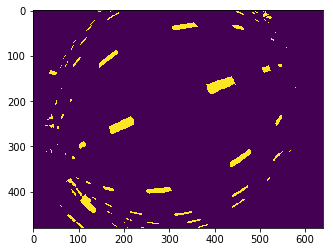

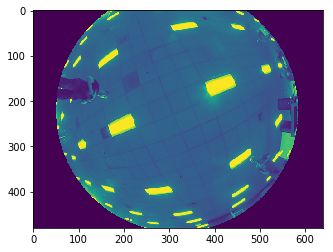

In [161]:
f = open("../../logs/cl20190420/cycloid-20190420-172107.rec", "rb")
ok, frame = recordreader.read_frame(f)
gray = frame['yuv420'][:480]
f.close()

plt.imshow(gray > 240)
plt.show()
plt.imshow(gray * ceilmask)

(-24.531490390535303,
 24.673203036322757,
 -24.35712654885758,
 22.665510897490748)

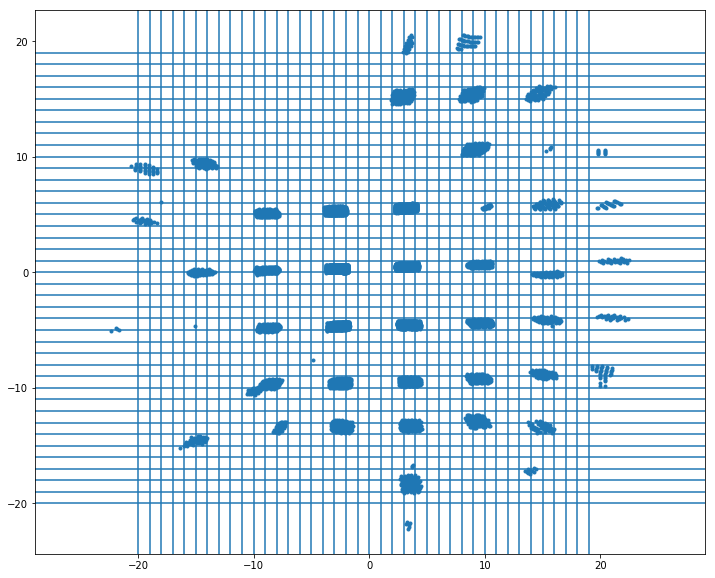

In [134]:
def remap(xi, yi, theta, Z, ceilpx):
    S, C = np.sin(theta), np.cos(theta)
    R = np.array([[C, S], [-S, C]])*Z
    p = np.dot(pts[0][ceilpx[ceilmask]], R.T) + np.array([xi, yi])
    return p

plt.figure(figsize=(12,10))
#xy = remap(0.7, -2, 1.2, 4, gray > 220)
#xy = remap(0.8, 1.8, 1.19, 4, gray > 220)
xy = remap(0, 0, 2.7284349649214974, 4, gray > 220)
plt.plot(*xy.T, '.')
for i in range(-20, 20):
    plt.axvline(i)
for j in range(-20, 20):
    plt.axhline(j)
plt.axis('equal')

In [116]:
n, msk = cv2.connectedComponents((ceilmask*gray > 220).astype(np.uint8))
np.argmax(np.histogram(msk, n)[0][1:])

15

In [131]:
np.linalg.svd(np.cov(remap(0, 0, 0, 4, msk == 16).T))

(array([[-0.9158581 ,  0.40150212],
        [ 0.40150212,  0.9158581 ]]),
 array([0.29284778, 0.0354341 ]),
 array([[-0.9158581 ,  0.40150212],
        [ 0.40150212,  0.9158581 ]]))

In [133]:
np.arctan2(0.4015, -0.91585)

2.7284349649214974

(-6.311080624125765, 6.1962210431321125, -4.826904434189364, 5.92659248732047)

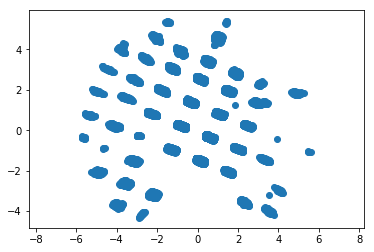

In [142]:
plt.scatter(*pts[0][msk[ceilmask] != 0].T)
plt.axis('equal')

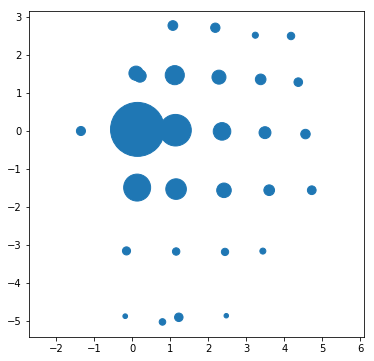

In [219]:
import ba

def features(greyimg, thr=230):
    # get ceiling light features from fisheye image
    n, msk = cv2.connectedComponents((ba.ceilmask*greyimg > thr).astype(np.uint8))
    F = []
    N = []
    C = []
    for i in range(n):
        P = ba.pts[0][msk[ba.ceilmask] == i+1]
        if P.shape[0] < 20:
            continue
        N.append(P.shape[0])
        M = np.mean(P, axis=0)
        C.append(np.linalg.svd(np.cov((P - M).T))[0][:, 0])
        F.append(M)
    
    return np.array(F), np.array(N), np.array(C)

F, N, C = features(gray, 240)
plt.figure(figsize=(6,6))
plt.axis('equal')
orient = np.dot(N, C)
S, C = orient / np.linalg.norm(orient)
R = np.array([[C, -S], [S, C]])
plt.scatter(*np.dot(R, F.T), N)


In [224]:
f = open("../../logs/cl20190420/cycloid-20190420-173642.rec", "rb")
for frame in recordreader.RecordIterator(f):
    gray = frame['yuv420'][:480]
    F, N, C = features(gray)
    S, C = orient / np.linalg.norm(orient)
    #R = np.array([[C, -S], [S, C]])
    #x, y = np.dot(R, F.T)
    x, y = F.T
    img = np.zeros((480, 640, 3), np.uint8)
    for i in range(len(x)):
        cv2.circle(img, (int(16*320 + x[i] * 800), int(16*240 + y[i] * 800)), int(8*np.sqrt(N[i])), (0, 255, 0), shift=4)
    cv2.imshow("map", img)
    #cv2.imshow("gray", gray)
    k = cv2.waitKey(1)
    if k == ord('q'):
        break

f.close()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

In [189]:
??cv2.circle